#Preparacion del entorno


In [ ]:
!pip install skforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.8/343.8 KB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 5.8 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.65.0
    Uninstalling tqdm-4.65.0:
      Successfully uninstalled tqdm-4.65.0


In [ ]:
# Advertencias
import warnings
warnings.filterwarnings("ignore")

# Tratamiento de datos
import pandas as pd
import numpy as np

#Graficos
import matplotlib.pyplot as plt
import seaborn as sb
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

#Modelado
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

#Evolucion
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#configuracion de colores
plt.style.use('fivethirtyeight')

In [ ]:
#IMPORTAR DATOS
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
btc = pd.read_csv("/content/drive/MyDrive/Analisis de Decisiones/Taller 2/Bitcoin.csv")
eth = pd.read_csv("/content/drive/MyDrive/Analisis de Decisiones/Taller 2/Ethereum.csv")
png = pd.read_csv("/content/drive/MyDrive/Analisis de Decisiones/Taller 2/Pangolin.csv")


#Organizacion de los 3 DataFrames


In [ ]:
btc.info()
print("\n\n")
eth.info()
print("\n\n")
png.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975 entries, 0 to 974
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          975 non-null    int64  
 1   Date                975 non-null    object 
 2   Open                975 non-null    float64
 3   High                975 non-null    float64
 4   Low                 975 non-null    float64
 5   Close               975 non-null    float64
 6   Volume              975 non-null    float64
 7   Market Cap          975 non-null    float64
 8   Circulating Supply  975 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 68.7+ KB



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 822 entries, 0 to 821
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          822 non-null    int64  
 1   Date                822 non-null   

In [ ]:
#Cambiar los nombres que tienen espacio
btc = btc.rename(columns={'Market Cap': 'MarketCap'})
btc = btc.rename(columns={'Circulating Supply': 'CirculatingSupply'})
eth = eth.rename(columns={'Market Cap': 'MarketCap'})
eth = eth.rename(columns={'Circulating Supply': 'CirculatingSupply'})
png = png.rename(columns={'Market Cap': 'MarketCap'})
png = png.rename(columns={'Circulating Supply': 'CirculatingSupply'})


#Transformar Date y validar que esten todos los registros en los 3 dataset
btc['Date'] = pd.to_datetime(btc['Date'], format = '%Y-%m-%d')
btc = btc.set_index('Date')
btc = btc.asfreq('D')
btc = btc.sort_index()

eth['Date'] = pd.to_datetime(eth['Date'], format = '%Y-%m-%d')
eth = eth.set_index('Date')
eth = eth.asfreq('D')
eth = eth.sort_index()

png['Date'] = pd.to_datetime(png['Date'], format = '%Y-%m-%d')
png = png.set_index('Date')
png = png.asfreq('D')
png = png.sort_index()

#Validar que el indice temporal esta completo
print("Bitcoin completo: ",(btc.index == pd.date_range(start = btc.index.min(), end = btc.index.max(), freq = btc.index.freq)).all())
print("Ethereum completo: ",(eth.index == pd.date_range(start = eth.index.min(), end = eth.index.max(), freq = eth.index.freq)).all())
print("Pangolin completo: ",(png.index == pd.date_range(start = png.index.min(), end = png.index.max(), freq = png.index.freq)).all())

Bitcoin completo:  True
Ethereum completo:  True
Pangolin completo:  True


In [ ]:
btc.drop('Unnamed: 0', axis = 1,inplace = True) #Eliminar columna inutil
eth.drop('Unnamed: 0', axis = 1,inplace = True) #Eliminar columna inutil
png.drop('Unnamed: 0', axis = 1,inplace = True) #Eliminar columna inutil

In [ ]:
#Construccion de conjuntos de entrenamiento, prueba y validacion (75,15,10)

endTrainBtc = btc.index[int(len(btc)/100*75)]
endTestBtc = btc.index[int(len(btc)/100*90)]
dataTrainBtc = btc.loc[:endTrainBtc, : ]
dataTestBtc = btc.loc[endTrainBtc:endTestBtc, : ]
validataBtc = btc.loc[endTestBtc:, : ]

print(f'Train data: {dataTrainBtc.index.min()} --- {dataTrainBtc.index.max()} n = {len(dataTrainBtc)}')
print(f'Test data: {dataTestBtc.index.min()} --- {dataTestBtc.index.max()} n = {len(dataTestBtc)}')
print(f'validation data: {validataBtc.index.min()} --- {validataBtc.index.max()} n = {len(validataBtc)}')

Train data: 2019-04-04 00:00:00 --- 2021-04-04 00:00:00 n = 732
Test data: 2021-04-04 00:00:00 --- 2021-08-28 00:00:00 n = 147
validation data: 2021-08-28 00:00:00 --- 2021-12-03 00:00:00 n = 98


In [ ]:
#Construccion de conjuntos de entrenamiento, prueba y validacion (75,15,10)

endTrainEth = eth.index[int(len(eth)/100*75)]
endTestEth = eth.index[int(len(eth)/100*90)]
dataTrainEth = eth.loc[:endTrainEth, : ]
dataTestEth = eth.loc[endTrainEth:endTestEth, : ]
validataEth = eth.loc[endTestEth:, : ]

print(f'Train data: {dataTrainEth.index.min()} --- {dataTrainEth.index.max()} n = {len(dataTrainEth)}')
print(f'Test data: {dataTestEth.index.min()} --- {dataTestEth.index.max()} n = {len(dataTestEth)}')
print(f'validation data: {validataEth.index.min()} --- {validataEth.index.max()} n = {len(validataEth)}')

Train data: 2019-09-04 00:00:00 --- 2021-05-12 00:00:00 n = 617
Test data: 2021-05-12 00:00:00 --- 2021-09-12 00:00:00 n = 124
validation data: 2021-09-12 00:00:00 --- 2021-12-03 00:00:00 n = 83


In [ ]:
#Construccion de conjuntos de entrenamiento, prueba y validacion (75,15,10)

endTrainPng = png.index[int(len(png)/100*75)]
endTestPng = png.index[int(len(png)/100*90)]
dataTrainPng = png.loc[:endTrainPng, : ]
dataTestPng = png.loc[endTrainPng:endTestPng, : ]
validataPng = png.loc[endTestPng:, : ]

print(f'Train data:      {dataTrainPng.index.min()} --- {dataTrainPng.index.max()} n = {len(dataTrainPng)}')
print(f'Test data:       {dataTestPng.index.min()} --- {dataTestPng.index.max()} n = {len(dataTestPng)}')
print(f'validation data: {validataPng.index.min()} --- {validataPng.index.max()} n = {len(validataPng)}')

Train data:      2021-04-27 00:00:00 --- 2021-10-12 00:00:00 n = 169
Test data:       2021-10-12 00:00:00 --- 2021-11-14 00:00:00 n = 34
validation data: 2021-11-14 00:00:00 --- 2021-12-06 00:00:00 n = 23


#Exploracion de los datos y modelo Bitcoin


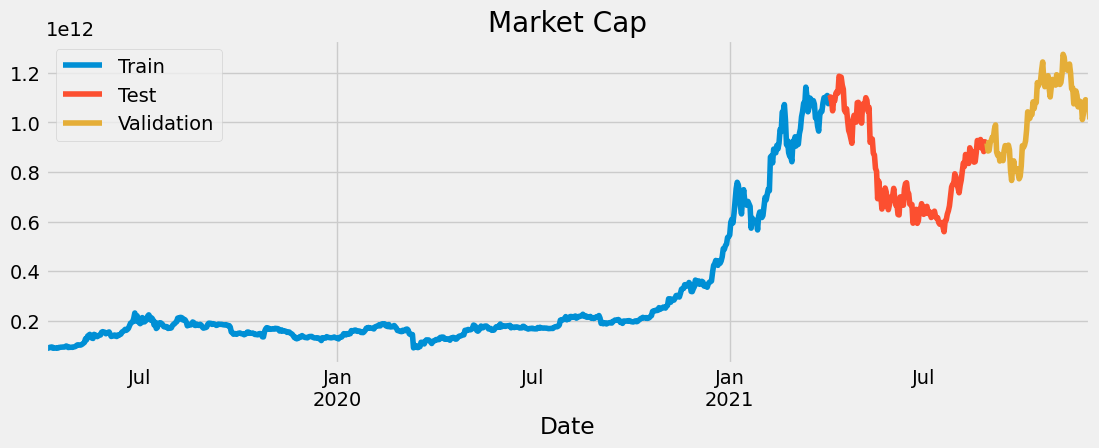

In [ ]:
#Grafica de la serie de tiempo
fig, ax = plt.subplots(figsize = (12,4))
dataTrainBtc.MarketCap.plot(ax = ax, label = 'Train')
dataTestBtc.MarketCap.plot(ax = ax, label = 'Test')
validataBtc.MarketCap.plot(ax = ax, label = 'Validation')
ax.set_title('Market Cap')
ax.legend()
plt.show()

In [ ]:
#identificar la estacionalidad por mes
fig, ax = plt.subplots(figsize = (10,5))
btc['mes'] = btc.index.month
btc.boxplot(column = 'MarketCap', by = 'mes',ax =ax)
btc.groupby('mes')['MarketCap'].median().plot(style = 'o-', ax = ax)
ax.set_ylabel('Market Cap')
ax.set_title('Distribucion de Capitalización del mercado por mes')
fig.suptitle('')
plt.show()

In [ ]:
#identificar la estacionalidad por dia semana
fig, ax = plt.subplots(figsize = (10,5))
btc['dia_semana'] = btc.index.day_of_week+1
btc.boxplot(column = 'MarketCap', by = 'dia_semana',ax =ax)
btc.groupby('dia_semana')['MarketCap'].median().plot(style = 'o-', ax = ax)
ax.set_ylabel('Capitalizacion del Mercado')
ax.set_title('Distribucion de Capitalizacion del Mercado por dia de la semana')
fig.suptitle('')
plt.show()

In [ ]:
#Grafico de autocorrelacion
fig, ax = plt.subplots(figsize = (7,3))
plot_acf(btc.MarketCap, ax = ax, lags = 100 )
plt.show()

In [ ]:
#Grafico de Autocorrelacion parcial
fig, ax = plt.subplots(figsize = (7,3))
plot_pacf(btc.MarketCap, ax = ax, lags = 100 )
plt.show

In [ ]:
#Modelado
forecaster = ForecasterAutoreg(regressor = DecisionTreeRegressor(),
                               lags = 24,
                               transformer_y = StandardScaler())
forecaster.fit(y = btc.loc[:endTestBtc,'MarketCap'])
forecaster

In [ ]:
metrica,predicciones = backtesting_forecaster(forecaster = forecaster,
                                              y = btc.MarketCap,
                                              initial_train_size = len(btc.loc[:endTestBtc]),
                                              steps = 24,
                                              metric = 'mean_absolute_error',
                                              refit = False,
                                              verbose = True)

In [ ]:
fig, ax  = plt.subplots(figsize = (12,5))
btc.loc[predicciones.index,'MarketCap'].plot(ax =ax, label = 'Prueba')
predicciones.plot(ax = ax, label = 'Pronostico')
ax.legend()
plt.show()

In [ ]:
metrica

In [ ]:
#Busqueda de hiperparametros
forecaster = ForecasterAutoreg(regressor = DecisionTreeRegressor(),
                               lags = 24,
                               transformer_y = StandardScaler())
forecaster.fit(y = btc.loc[:endTestBtc,'MarketCap'])
#Logs utilizados compredictores
lags_grid = [5,24, [1,2,3,23,24,25,47,48,49]]
#hiperparametros del regressor
param_grid = {'max_depth':[5,9,7,11],
       'criterion':['squared_error','absolute_error']}
results_grid = grid_search_forecaster(forecaster = forecaster, 
                                      y = btc.loc[:endTestBtc, 'MarketCap'],
                                      param_grid = param_grid,
                                      lags_grid = lags_grid,
                                      steps = 24,
                                      metric = 'mean_absolute_error',
                                      refit = False, 
                                      initial_train_size = len(btc[:endTrainBtc]),
                                      fixed_train_size = False,
                                      return_best = True,
                                      verbose = False)

In [ ]:
results_grid

In [ ]:
forecaster

In [ ]:
metrica,predicciones = backtesting_forecaster(forecaster = forecaster,
                                              y = btc.MarketCap,
                                              initial_train_size = len(btc.loc[:endTestBtc]),
                                              steps = 24,
                                              metric = 'mean_absolute_error',
                                              refit = False,
                                              verbose = False)

In [ ]:
fig, ax  = plt.subplots(figsize = (12,5))
btc.loc[predicciones.index,'MarketCap'].plot(ax =ax, label = 'Prueba')
predicciones.plot(ax = ax, label = 'Pronostico')
ax.legend()
plt.show()

In [ ]:
metrica

150017442168.90308

In [ ]:
forecaster.get_feature_importance()

#Exploracion de datos para Ethereum

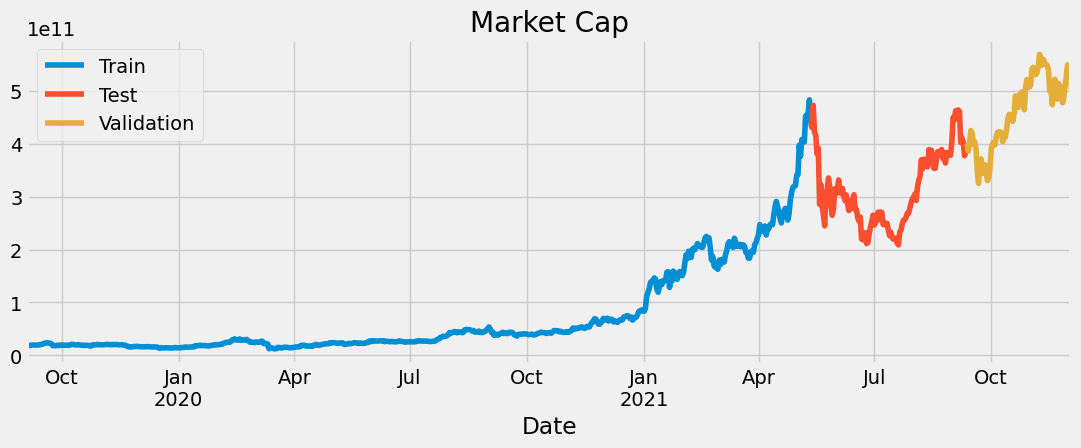

In [ ]:
#Grafica de la serie de tiempo
fig, ax = plt.subplots(figsize = (12,4))
dataTrainEth.MarketCap.plot(ax = ax, label = 'Train')
dataTestEth.MarketCap.plot(ax = ax, label = 'Test')
validataEth.MarketCap.plot(ax = ax, label = 'Validation')
ax.set_title('Market Cap')
ax.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

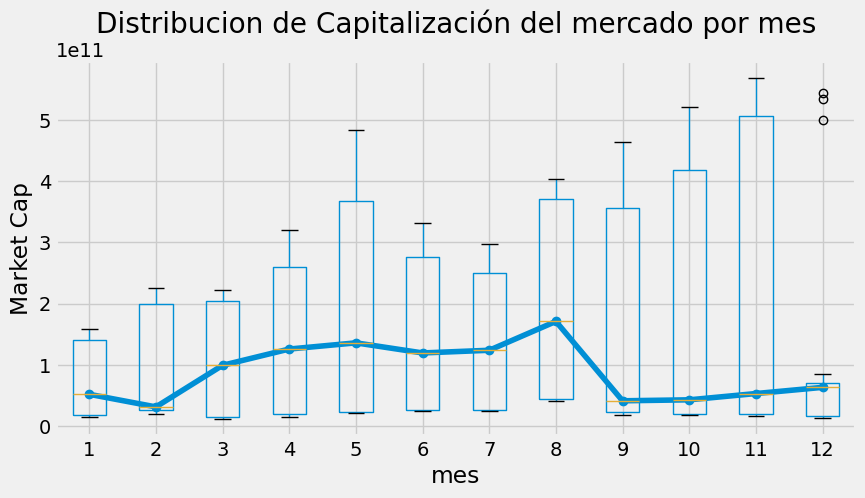

In [ ]:
#identificar la estacionalidad por mes
fig, ax = plt.subplots(figsize = (10,5))
eth['mes'] = eth.index.month
eth.boxplot(column = 'MarketCap', by = 'mes',ax =ax)
eth.groupby('mes')['MarketCap'].median().plot(style = 'o-', ax = ax)
ax.set_ylabel('Market Cap')
ax.set_title('Distribucion de Capitalización del mercado por mes')
fig.suptitle('')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

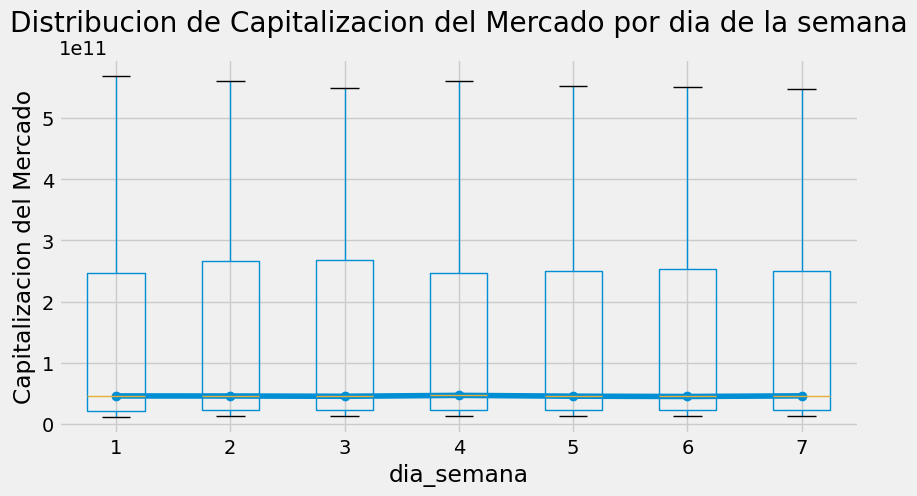

In [ ]:
#identificar la estacionalidad por dia semana
fig, ax = plt.subplots(figsize = (10,5))
eth['dia_semana'] = eth.index.day_of_week+1
eth.boxplot(column = 'MarketCap', by = 'dia_semana',ax =ax)
eth.groupby('dia_semana')['MarketCap'].median().plot(style = 'o-', ax = ax)
ax.set_ylabel('Capitalizacion del Mercado')
ax.set_title('Distribucion de Capitalizacion del Mercado por dia de la semana')
fig.suptitle('')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

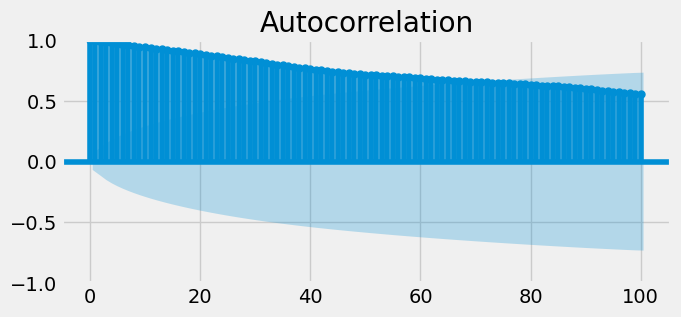

In [ ]:
#Grafico de autocorrelacion
fig, ax = plt.subplots(figsize = (7,3))
plot_acf(eth.MarketCap, ax = ax, lags = 100 )
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

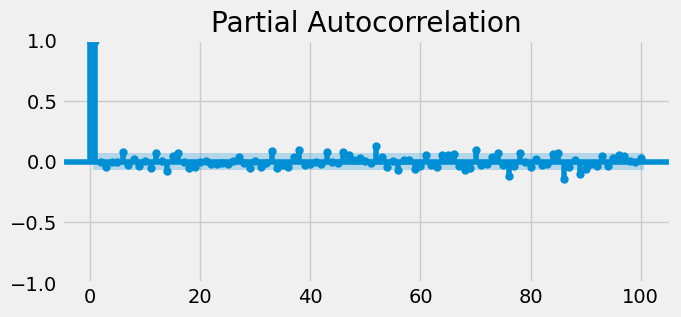

In [ ]:
#Grafico de Autocorrelacion parcial
fig, ax = plt.subplots(figsize = (7,3))
plot_pacf(eth.MarketCap, ax = ax, lags = 100 )
plt.show

In [ ]:
#Modelado
forecaster = ForecasterAutoreg(regressor = DecisionTreeRegressor(),
                               lags = 24,
                               transformer_y = StandardScaler())
forecaster.fit(y = eth.loc[:endTestEth,'MarketCap'])
forecaster

ForecasterAutoreg 
Regressor: DecisionTreeRegressor() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2019-09-04 00:00:00'), Timestamp('2021-09-12 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'} 
Creation date: 2023-03-31 03:37:25 
Last fit date: 2023-03-31 03:37:25 
Skforecast version: 0.7.0 
Python version: 3.9.16 
Forecaster id: None 

In [ ]:
metrica,predicciones = backtesting_forecaster(forecaster = forecaster,
                                              y = eth.MarketCap,
                                              initial_train_size = len(eth.loc[:endTestEth]),
                                              steps = 24,
                                              metric = 'mean_absolute_error',
                                              refit = False,
                                              verbose = True)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 740
Number of observations used for backtesting: 82
    Number of folds: 4
    Number of steps per fold: 24
    Last fold only includes 10 observations.

Data partition in fold: 0
    Training:   2019-09-04 00:00:00 -- 2021-09-12 00:00:00  (n=740)
    Validation: 2021-09-13 00:00:00 -- 2021-10-06 00:00:00  (n=24)
Data partition in fold: 1
    Training:   2019-09-04 00:00:00 -- 2021-09-12 00:00:00  (n=740)
    Validation: 2021-10-07 00:00:00 -- 2021-10-30 00:00:00  (n=24)
Data partition in fold: 2
    Training:   2019-09-04 00:00:00 -- 2021-09-12 00:00:00  (n=740)
    Validation: 2021-10-31 00:00:00 -- 2021-11-23 00:00:00  (n=24)
Data partition in fold: 3
    Training:   2019-09-04 00:00:00 -- 2021-09-12 00:00:00  (n=740)
    Validation: 2021-11-24 00:00:00 -- 2021-12-03 00:00:00  (n=10)



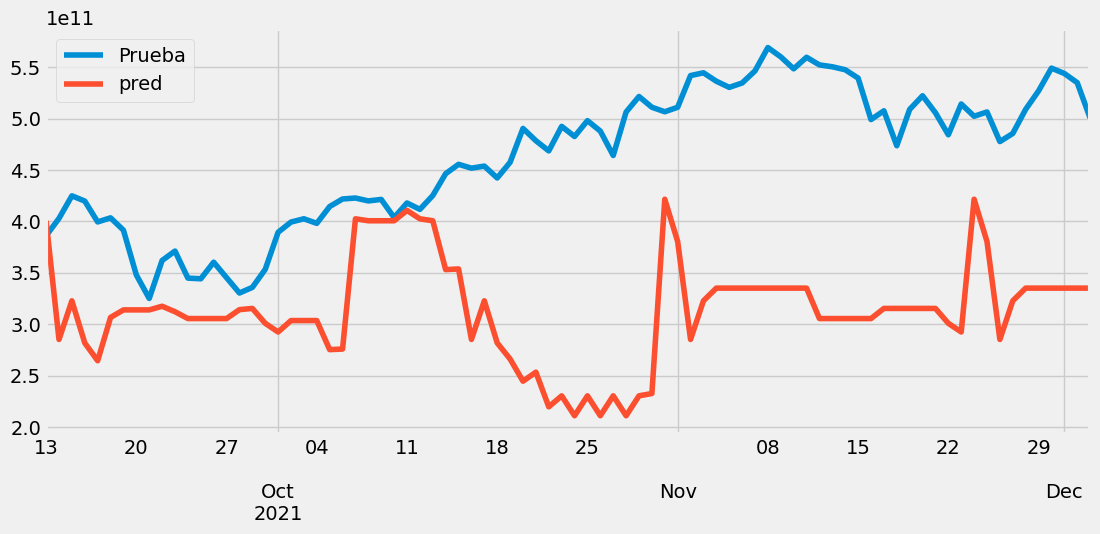

In [ ]:
fig, ax  = plt.subplots(figsize = (12,5))
eth.loc[predicciones.index,'MarketCap'].plot(ax =ax, label = 'Prueba')
predicciones.plot(ax = ax, label = 'Pronostico')
ax.legend()
plt.show()

In [ ]:
metrica

149095254040.4878

In [ ]:
#Busqueda de hiperparametros
forecaster = ForecasterAutoreg(regressor = DecisionTreeRegressor(),
                               lags = 24,
                               transformer_y = StandardScaler())
forecaster.fit(y = eth.loc[:endTestEth,'MarketCap'])
#Logs utilizados compredictores
lags_grid = [5,24, [1,2,3,23,24,25,47,48,49]]
#hiperparametros del regressor
param_grid = {'max_depth':[5,9,7,11],
       'criterion':['squared_error','absolute_error']}
results_grid = grid_search_forecaster(forecaster = forecaster, 
                                      y = eth.loc[:endTestEth, 'MarketCap'],
                                      param_grid = param_grid,
                                      lags_grid = lags_grid,
                                      steps = 24,
                                      metric = 'mean_absolute_error',
                                      refit = False, 
                                      initial_train_size = len(eth[:endTrainEth]),
                                      fixed_train_size = False,
                                      return_best = True,
                                      verbose = False)

Number of models compared: 24.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:01<00:00,  1.78it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 47 48 49] 
  Parameters: {'criterion': 'squared_error', 'max_depth': 11}
  Backtesting metric: 48422584147.772354



In [ ]:
results_grid

,lags,params,mean_absolute_error,criterion,max_depth
19,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'criterion': 'squared_error', 'max_depth': 11}",4.842258e+10,squared_error,11
6,"[1, 2, 3, 4, 5]","{'criterion': 'absolute_error', 'max_depth': 7}",6.438712e+10,absolute_error,7
23,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'criterion': 'absolute_error', 'max_depth': 11}",6.485989e+10,absolute_error,11
21,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'criterion': 'absolute_error', 'max_depth': 9}",6.557770e+10,absolute_error,9
7,"[1, 2, 3, 4, 5]","{'criterion': 'absolute_error', 'max_depth': 11}",6.609841e+10,absolute_error,11
22,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'criterion': 'absolute_error', 'max_depth': 7}",7.214336e+10,absolute_error,7
16,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'criterion': 'squared_error', 'max_depth': 5}",7.616015e+10,squared_error,5
4,"[1, 2, 3, 4, 5]","{'criterion': 'absolute_error', 'max_depth': 5}",8.502328e+10,absolute_error,5
20,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'criterion': 'absolute_error', 'max_depth': 5}",8.758894e+10,absolute_error,5
18,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'criterion': 'squared_error', 'max_depth': 7}",8.763752e+10,squared_error,7


In [ ]:
forecaster

ForecasterAutoreg 
Regressor: DecisionTreeRegressor(max_depth=11) 
Lags: [ 1  2  3 23 24 25 47 48 49] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 49 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2019-09-04 00:00:00'), Timestamp('2021-09-12 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 11, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'} 
Creation date: 2023-03-31 03:40:07 
Last fit date: 2023-03-31 03:40:09 
Skforecast version: 0.7.0 
Python version: 3.9.16 
Forecaster id: None 

In [ ]:
metrica,predicciones = backtesting_forecaster(forecaster = forecaster,
                                              y = eth.MarketCap,
                                              initial_train_size = len(eth.loc[:endTestEth]),
                                              steps = 24,
                                              metric = 'mean_absolute_error',
                                              refit = False,
                                              verbose = False)

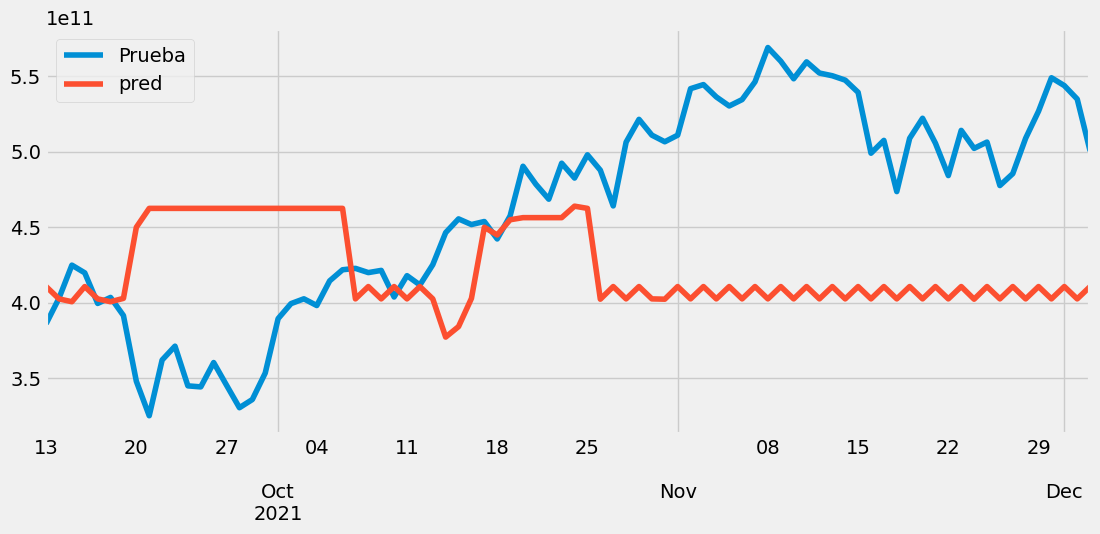

In [ ]:
fig, ax  = plt.subplots(figsize = (12,5))
eth.loc[predicciones.index,'MarketCap'].plot(ax =ax, label = 'Prueba')
predicciones.plot(ax = ax, label = 'Pronostico')
ax.legend()
plt.show()

In [ ]:
metrica

150017442168.90308

#Exploracion de datos y modelo para Pangolin

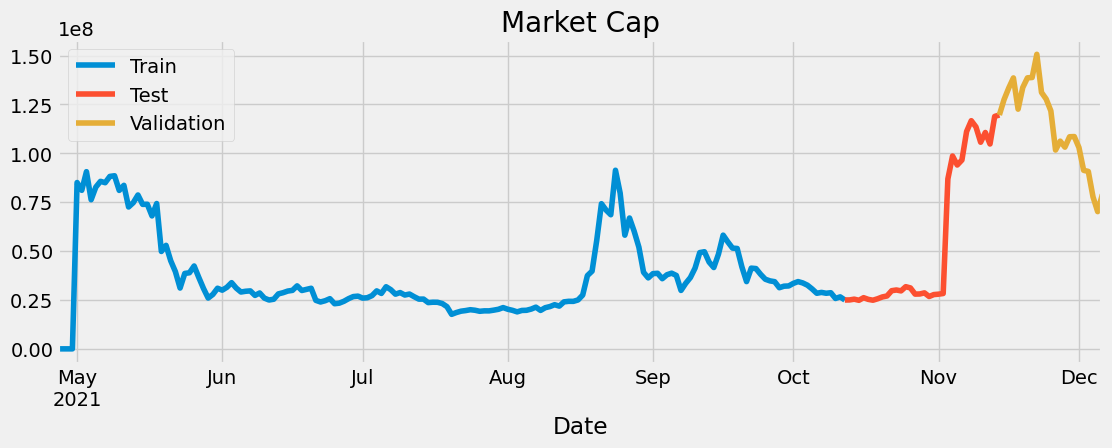

In [ ]:
#Grafica de la serie de tiempo
fig, ax = plt.subplots(figsize = (12,4))
dataTrainPng.MarketCap.plot(ax = ax, label = 'Train')
dataTestPng.MarketCap.plot(ax = ax, label = 'Test')
validataPng.MarketCap.plot(ax = ax, label = 'Validation')
ax.set_title('Market Cap')
ax.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

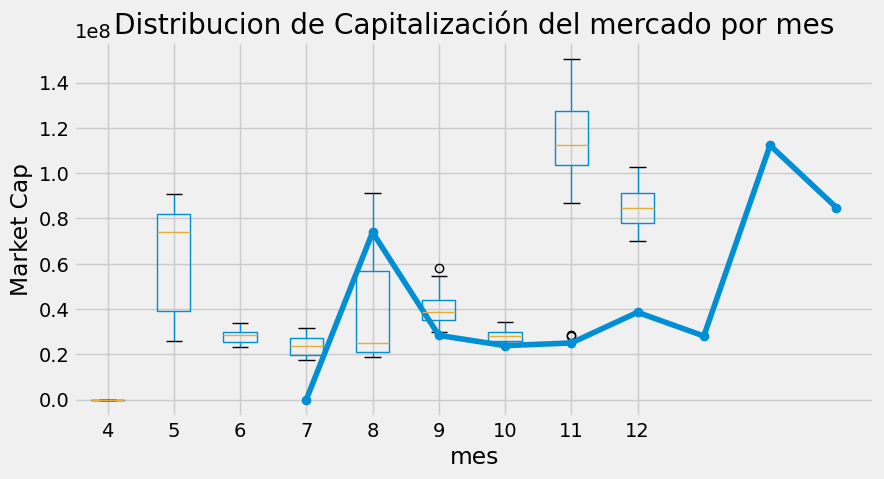

In [ ]:
#identificar la estacionalidad por mes
fig, ax = plt.subplots(figsize = (10,5))
png['mes'] = png.index.month
png.boxplot(column = 'MarketCap', by = 'mes',ax =ax)
png.groupby('mes')['MarketCap'].median().plot(style = 'o-', ax = ax)
ax.set_ylabel('Market Cap')
ax.set_title('Distribucion de Capitalización del mercado por mes')
fig.suptitle('')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

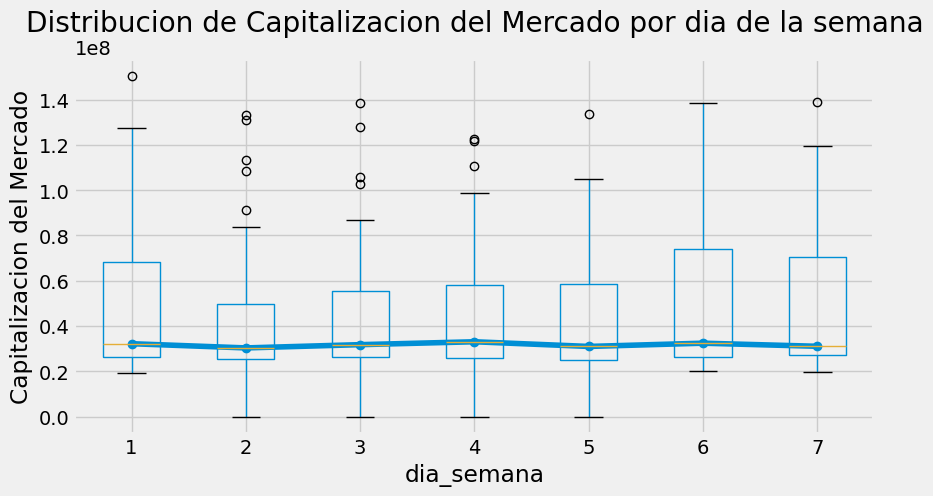

In [ ]:
#identificar la estacionalidad por dia semana
fig, ax = plt.subplots(figsize = (10,5))
png['dia_semana'] = png.index.day_of_week+1
png.boxplot(column = 'MarketCap', by = 'dia_semana',ax =ax)
png.groupby('dia_semana')['MarketCap'].median().plot(style = 'o-', ax = ax)
ax.set_ylabel('Capitalizacion del Mercado')
ax.set_title('Distribucion de Capitalizacion del Mercado por dia de la semana')
fig.suptitle('')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

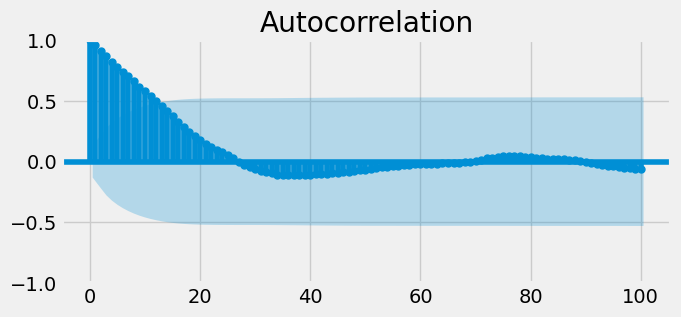

In [ ]:
#Grafico de autocorrelacion
fig, ax = plt.subplots(figsize = (7,3))
plot_acf(png.MarketCap, ax = ax, lags = 100 )
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

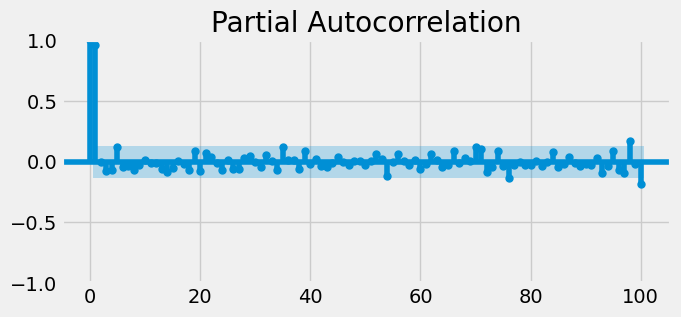

In [ ]:
#Grafico de Autocorrelacion parcial
fig, ax = plt.subplots(figsize = (7,3))
plot_pacf(png.MarketCap, ax = ax, lags = 100 )
plt.show

In [ ]:
#Modelado
forecaster = ForecasterAutoreg(regressor = DecisionTreeRegressor(),
                               lags = 24,
                               transformer_y = StandardScaler())
forecaster.fit(y = png.loc[:endTestPng,'MarketCap'])
forecaster

ForecasterAutoreg 
Regressor: DecisionTreeRegressor() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2021-04-27 00:00:00'), Timestamp('2021-11-14 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'} 
Creation date: 2023-03-31 03:48:05 
Last fit date: 2023-03-31 03:48:05 
Skforecast version: 0.7.0 
Python version: 3.9.16 
Forecaster id: None 

In [ ]:
metrica,predicciones = backtesting_forecaster(forecaster = forecaster,
                                              y = png.MarketCap,
                                              initial_train_size = len(png.loc[:endTestPng]),
                                              steps = 24,
                                              metric = 'mean_absolute_error',
                                              refit = False,
                                              verbose = True)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 202
Number of observations used for backtesting: 22
    Number of folds: 1
    Number of steps per fold: 24
    Last fold only includes 22 observations.

Data partition in fold: 0
    Training:   2021-04-27 00:00:00 -- 2021-11-14 00:00:00  (n=202)
    Validation: 2021-11-15 00:00:00 -- 2021-12-06 00:00:00  (n=22)



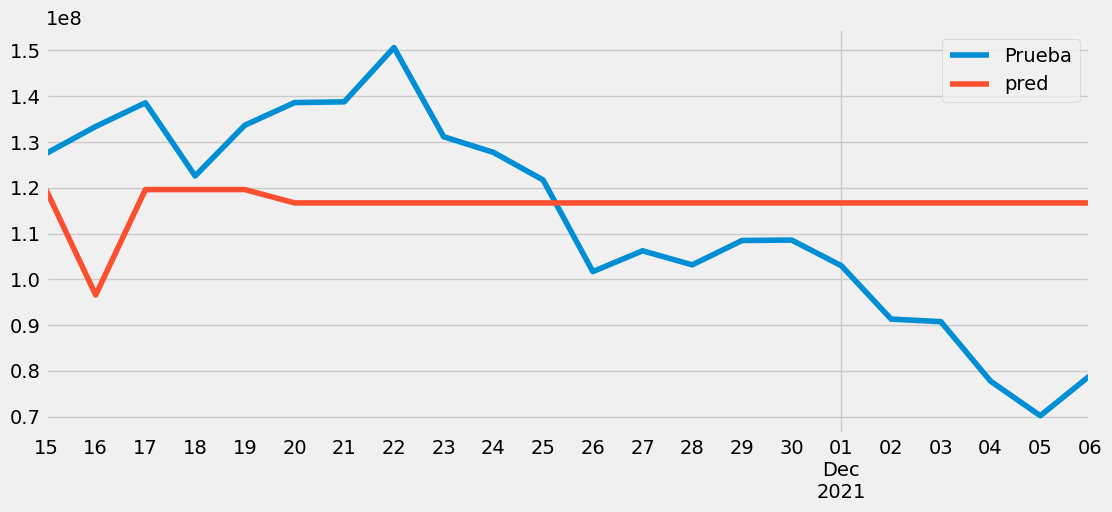

In [ ]:
fig, ax  = plt.subplots(figsize = (12,5))
png.loc[predicciones.index,'MarketCap'].plot(ax =ax, label = 'Prueba')
predicciones.plot(ax = ax, label = 'Pronostico')
ax.legend()
plt.show()

In [ ]:
metrica

19669353.5

In [ ]:
#Busqueda de hiperparametros
forecaster = ForecasterAutoreg(regressor = DecisionTreeRegressor(),
                               lags = 24,
                               transformer_y = StandardScaler())
forecaster.fit(y = png.loc[:endTestPng,'MarketCap'])
#Logs utilizados compredictores
lags_grid = [5,24, [1,2,3,23,24,25,47,48,49]]
#hiperparametros del regressor
param_grid = {'max_depth':[5,9,7,11],
       'criterion':['squared_error','absolute_error']}
results_grid = grid_search_forecaster(forecaster = forecaster, 
                                      y = png.loc[:endTestPng, 'MarketCap'],
                                      param_grid = param_grid,
                                      lags_grid = lags_grid,
                                      steps = 24,
                                      metric = 'mean_absolute_error',
                                      refit = False, 
                                      initial_train_size = len(png[:endTrainPng]),
                                      fixed_train_size = False,
                                      return_best = True,
                                      verbose = False)

Number of models compared: 24.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:00<00:00,  4.89it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 47 48 49] 
  Parameters: {'criterion': 'absolute_error', 'max_depth': 5}
  Backtesting metric: 13215183.681818182



In [ ]:
results_grid

,lags,params,mean_absolute_error,criterion,max_depth
20,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'criterion': 'absolute_error', 'max_depth': 5}",1.321518e+07,absolute_error,5
16,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'criterion': 'squared_error', 'max_depth': 5}",1.325879e+07,squared_error,5
21,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'criterion': 'absolute_error', 'max_depth': 9}",1.371561e+07,absolute_error,9
19,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'criterion': 'squared_error', 'max_depth': 11}",1.390138e+07,squared_error,11
17,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'criterion': 'squared_error', 'max_depth': 9}",1.437512e+07,squared_error,9
23,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'criterion': 'absolute_error', 'max_depth': 11}",1.445773e+07,absolute_error,11
22,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'criterion': 'absolute_error', 'max_depth': 7}",1.453184e+07,absolute_error,7
18,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'criterion': 'squared_error', 'max_depth': 7}",1.456550e+07,squared_error,7
0,"[1, 2, 3, 4, 5]","{'criterion': 'squared_error', 'max_depth': 5}",1.676024e+07,squared_error,5
2,"[1, 2, 3, 4, 5]","{'criterion': 'squared_error', 'max_depth': 7}",1.706381e+07,squared_error,7


In [ ]:
forecaster

ForecasterAutoreg 
Regressor: DecisionTreeRegressor(criterion='absolute_error', max_depth=5) 
Lags: [ 1  2  3 23 24 25 47 48 49] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 49 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2021-04-27 00:00:00'), Timestamp('2021-11-14 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'} 
Creation date: 2023-03-31 03:49:36 
Last fit date: 2023-03-31 03:49:37 
Skforecast version: 0.7.0 
Python version: 3.9.16 
Forecaster id: None 

In [ ]:
metrica,predicciones = backtesting_forecaster(forecaster = forecaster,
                                              y = png.MarketCap,
                                              initial_train_size = len(png.loc[:endTestPng]),
                                              steps = 24,
                                              metric = 'mean_absolute_error',
                                              refit = False,
                                              verbose = False)

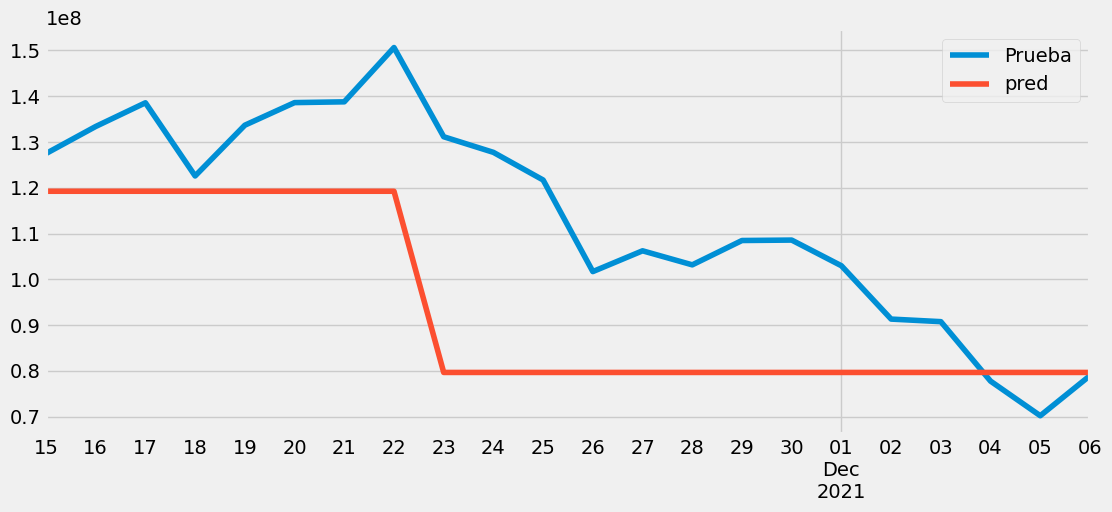

In [ ]:
fig, ax  = plt.subplots(figsize = (12,5))
png.loc[predicciones.index,'MarketCap'].plot(ax =ax, label = 'Prueba')
predicciones.plot(ax = ax, label = 'Pronostico')
ax.legend()
plt.show()

In [ ]:
metrica

20883454.545454547

In [ ]:
forecaster.get_feature_importance()

,feature,importance
0,lag_1,0.823323
1,lag_2,0.000000
2,lag_3,0.031901
3,lag_23,0.003487
4,lag_24,0.025801
5,lag_25,0.011061
6,lag_47,0.003986
7,lag_48,0.028357
8,lag_49,0.072085
